# 숙명여자대학교 기계시스템학부 딥러닝 2024: Lab2

## Topic: **nn Module Autoencoder**
## (강사: 심주용)


# Barebore Pytorch - Review
## Weight Initialization

Weight initialization is crucial in deep learning as it can significantly impact the model's convergence and performance. This tutorial covers the process of initializing weights and biases in a neural network using PyTorch, focusing on a three-layer fully connected network trained on the FashionMNIST dataset.


### Initializing Weights and Biases
In the NeuralNetwork class, we define the layers of the neural network with custom parameters using nn.Parameter. Each layer has its weights and biases, represented as matrices and vectors, respectively. We use PyTorch's torch.Tensor to define these parameters.

### Kaiming (He) Initialization
We apply Kaiming (or He) initialization to the weights using nn.init.kaiming_uniform_. This method is particularly suited for layers followed by ReLU activation functions, as it considers the nonlinearity of the activations. The initialization helps prevent vanishing or exploding gradients during training, promoting faster convergence and improved performance.

Kaiming initialization sets the tensor values uniformly in the range
[−a,a], where a=5 . This range is derived from the number of input and output units in the tensor, ensuring that the variance remains constant across layers.

### Zero Initialization for Biases
The biases are initialized to zero using nn.init.constant_. This is a common practice as it starts the neurons with an output of zero before adjusting during training, allowing the network to learn the bias for each neuron.

### Forward Pass
In the forward method, the input tensor is flattened and passed through the linear layers with ReLU activations, except for the last layer, which directly outputs the logits. This method defines how the data flows through the network, utilizing the initialized weights and biases.

### Training and Testing
The model is then compiled, trained, and evaluated. During training, the weights and biases are automatically adjusted through backpropagation. The weight initialization plays a critical role in ensuring that these adjustments lead to effective learning.

### Outlook
Proper weight initialization, like Kaiming initialization used here, is essential for training deep neural networks efficiently. It helps in maintaining a stable gradient flow across layers, leading to faster and more reliable convergence during training.

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 28*28
        self.hidden_size = 512
        self.output_size = 10

        # Initialize weights and biases for linear layers
        self.weight1 = nn.Parameter(torch.Tensor(self.hidden_size, self.input_size))
        self.bias1 = nn.Parameter(torch.Tensor(self.hidden_size))
        self.weight2 = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size))
        self.bias2 = nn.Parameter(torch.Tensor(self.hidden_size))
        self.weight3 = nn.Parameter(torch.Tensor(self.output_size, self.hidden_size))
        self.bias3 = nn.Parameter(torch.Tensor(self.output_size))

        # Kaiming initialization for weights
        nn.init.kaiming_uniform_(self.weight1, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.weight2, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.weight3, nonlinearity='relu')

        # Initialize biases to zero
        nn.init.constant_(self.bias1, 0)
        nn.init.constant_(self.bias2, 0)
        nn.init.constant_(self.bias3, 0)

    def forward(self, x):
        # Flatten the input tensor
        x = x.view(-1, self.input_size)

        # Apply the first linear layer and ReLU
        x = F.relu(F.linear(x, self.weight1, self.bias1))
        # Apply the second linear layer and ReLU
        x = F.relu(F.linear(x, self.weight2, self.bias2))
        # Apply the third linear layer
        logits = F.linear(x, self.weight3, self.bias3)

        return logits

# Assuming 'device' is defined elsewhere, e.g.,
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork().to(device)
print(model)

# Initialize the model, loss function, and optimizer
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the training loop
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Define the testing loop
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')


NeuralNetwork()
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Epoch 1
-------------------------------
loss: 2.266513  [    0/60000]
loss: 0.514421  [ 6400/60000]
loss: 0.408110  [12800/60000]
loss: 0.459795  [19200/60000]
loss: 0.432227  [25600/60000]
loss: 0.412075  [32000/60000]
loss: 0.349046  [38400/60000]
loss: 0.548770  [44800/60000]
loss: 0.423509  [51200/60000]
loss: 0.461233  [57600/60000]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.416501 

Epoch 2
-------------------------------
loss: 0.249283  [    0/60000]
loss: 0.337073  [ 6400/60000]
loss: 0.280285  [12800/60000]
loss: 0.386535  [19200/60000]
loss: 0.421984  [25600/60000]
loss: 0.367151  [32000/60000]
loss: 0.343159  [38400/60000]
loss: 0.497576  [44800/60000]
loss: 0.363690  [51200/60000]
loss: 0.413945  [57600/60000]
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.392135 

Epoch 3
-------------------------------
loss: 0.202920  [    0/60000]
loss: 0.314568  [ 6400/60000]
loss: 

# Autoencoder

## Data Loading and Preparation
In this part, we load the MNIST dataset, which consists of handwritten digits, and prepare it for training and testing. We use PyTorch's datasets and transforms modules to download and transform the data into a suitable format. The data is filtered to include only the digits 1, 5, and 6. Each image is converted to a tensor and flattened since our neural network will use fully connected layers. Normalization is applied to the images by scaling pixel values to the range [0, 1]. This process helps in reducing the complexity of the model's calculations and improves the training efficiency.

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Load data
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Select only digits 1, 5, 6 for training and testing
train_mask = (mnist.targets == 1) | (mnist.targets == 5) | (mnist.targets == 6)
test_mask = (mnist_test.targets == 1) | (mnist_test.targets == 5) | (mnist_test.targets == 6)

train_imgs = mnist.data[train_mask].float() / 255
train_labels = mnist.targets[train_mask]
test_imgs = mnist_test.data[test_mask].float() / 255
test_labels = mnist_test.targets[test_mask]

print(f"The number of training images: {train_imgs.shape[0]}, shape: {train_imgs.shape}")
print(f"The number of testing images: {test_imgs.shape[0]}, shape: {test_imgs.shape}")


100%|██████████| 9912422/9912422 [00:00<00:00, 79375225.51it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21623651.16it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21623377.74it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5601449.21it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

The number of training images: 18081, shape: torch.Size([18081, 28, 28])
The number of testing images: 2985, shape: torch.Size([2985, 28, 28])


## Define Model Structure and Training
Here, we define the structure of our autoencoder, which consists of an encoder and a decoder. The encoder compresses the input image into a lower-dimensional latent space, while the decoder reconstructs the image from the latent space representation. We use fully connected layers (nn.Linear) with ReLU activations for both parts. The autoencoder class combines these two components. We then compile the model using the Adam optimizer and mean squared error loss function, which is common for reconstruction tasks. The training process involves feeding the input data through the autoencoder to generate reconstructed images and updating the model weights to minimize the reconstruction error.

In [13]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

# Load and transform data
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Filter data to get only digits 1, 5, and 6
def filter_indices(dataset, digits):
    indices = []
    for index in range(len(dataset)):
        if dataset.targets[index] in digits:
            indices.append(index)
    return indices

train_indices = filter_indices(mnist_train, [1, 5, 6])
test_indices = filter_indices(mnist_test, [1, 5, 6])

# Create subsets
train_data = Subset(mnist_train, train_indices)
test_data = Subset(mnist_test, test_indices)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [14]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 500),
            nn.ReLU(),
            nn.Linear(500, 300),
            nn.ReLU(),
            nn.Linear(300, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 300),
            nn.ReLU(),
            nn.Linear(300, 500),
            nn.ReLU(),
            nn.Linear(500, 28*28)
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the autoencoder and optimizer
autoencoder = Autoencoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
for epoch in range(10):
    for batch, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28*28)  # Flatten the images
        optimizer.zero_grad()
        output = autoencoder(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f'Epoch {epoch+1}, Batch {batch}, Loss: {loss.item()}')

Epoch 1, Batch 0, Loss: 0.10351859033107758
Epoch 1, Batch 100, Loss: 0.03714611753821373
Epoch 1, Batch 200, Loss: 0.031116168946027756
Epoch 2, Batch 0, Loss: 0.0325968936085701
Epoch 2, Batch 100, Loss: 0.0300272386521101
Epoch 2, Batch 200, Loss: 0.03211086988449097
Epoch 3, Batch 0, Loss: 0.028497472405433655
Epoch 3, Batch 100, Loss: 0.02953959070146084
Epoch 3, Batch 200, Loss: 0.029181383550167084
Epoch 4, Batch 0, Loss: 0.026793694123625755
Epoch 4, Batch 100, Loss: 0.03238571062684059
Epoch 4, Batch 200, Loss: 0.025654373690485954
Epoch 5, Batch 0, Loss: 0.027507927268743515
Epoch 5, Batch 100, Loss: 0.02284306474030018
Epoch 5, Batch 200, Loss: 0.027384743094444275
Epoch 6, Batch 0, Loss: 0.026917187497019768
Epoch 6, Batch 100, Loss: 0.027055634185671806
Epoch 6, Batch 200, Loss: 0.026168759912252426
Epoch 7, Batch 0, Loss: 0.02237783931195736
Epoch 7, Batch 100, Loss: 0.024818088859319687
Epoch 7, Batch 200, Loss: 0.026552949100732803
Epoch 8, Batch 0, Loss: 0.025792669504

## Evaluate and Visualize Results
After training, we evaluate the model's performance by visualizing how well it can separate the different digits in the latent space. We randomly select a subset of the test images, pass them through the encoder to obtain their latent representations, and plot these in a scatter plot. Each digit type is represented with a different color. This visualization helps in understanding the quality of the learned representations and how well the model can distinguish between different digits based on their latent features.

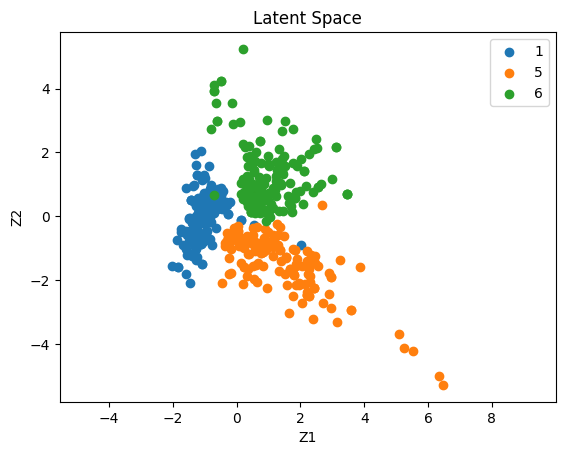

In [17]:
# Evaluate on test data
autoencoder.eval()
with torch.no_grad():
    idx = np.random.randint(0, len(test_labels), 500)
    test_x = test_imgs[idx]
    test_y = test_labels[idx]
    test_latent = autoencoder.encoder(test_x.reshape(-1, 28*28))

    plt.figure()
    plt.scatter(test_latent[:, 0][test_y == 1], test_latent[:, 1][test_y == 1], label='1')
    plt.scatter(test_latent[:, 0][test_y == 5], test_latent[:, 1][test_y == 5], label='5')
    plt.scatter(test_latent[:, 0][test_y == 6], test_latent[:, 1][test_y == 6], label='6')
    plt.title('Latent Space')
    plt.xlabel('Z1')
    plt.ylabel('Z2')
    plt.legend()
    plt.axis('equal')
    plt.show()


## Generate New Data and Visualize
In the final part, we demonstrate the generative capability of the autoencoder. We manually define new points in the latent space and use the decoder to generate images from these points. This shows how the decoder part of the autoencoder can create new images that resemble the training data, based on the learned features in the latent space. The resulting images are then plotted alongside the latent space to show the correlation between the latent representation and the reconstructed images.

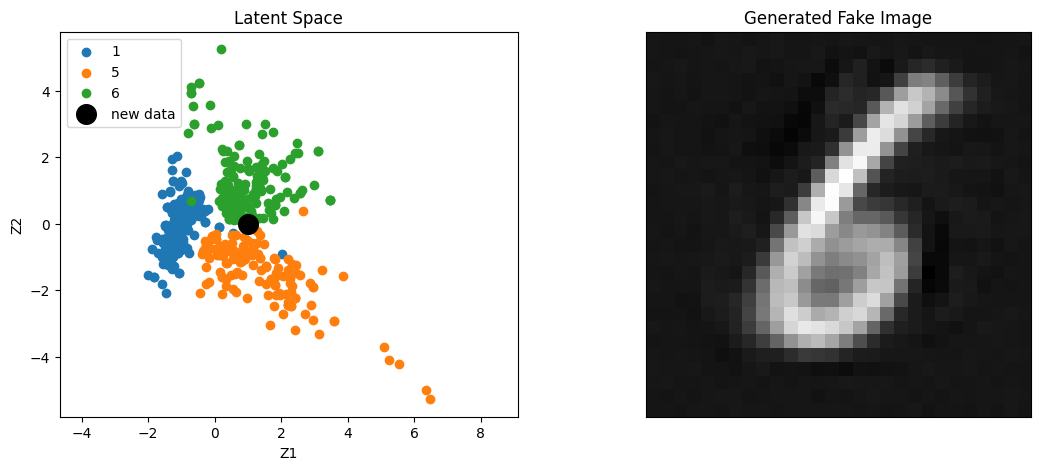

In [18]:
# Generate new data
new_data = torch.tensor([[1.0, 0.0]])
with torch.no_grad():
    fake_image = autoencoder.decoder(new_data)

    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(test_latent[:, 0][test_y == 1], test_latent[:, 1][test_y == 1], label='1')
    plt.scatter(test_latent[:, 0][test_y == 5], test_latent[:, 1][test_y == 5], label='5')
    plt.scatter(test_latent[:, 0][test_y == 6], test_latent[:, 1][test_y == 6], label='6')
    plt.scatter(new_data[:, 0], new_data[:, 1], c='k', marker='o', s=200, label='new data')
    plt.title('Latent Space')
    plt.xlabel('Z1')
    plt.ylabel('Z2')
    plt.legend(loc=2)
    plt.axis('equal')

    plt.subplot(1, 2, 2)
    plt.imshow(fake_image.reshape(28, 28), cmap='gray')
    plt.title('Generated Fake Image')
    plt.xticks([])
    plt.yticks([])
    plt.show()
